# Purpose

Determine the cause of the dip in user enagement on yammer at the end of july / beginning of august and make recommendations

## Solution

### possible problems to explore
Fallout ( a new feature was added and others were upset they didn't see it )

A bad feature was added ( people didn't like it and left )

An email marketing failed ( people didn't like the email and left )

Server Crashed

### Evaluation of analysis
So far we've identified that the majority of the users speak english, there is a 50/50 split on active vs pending

the engaged cohort looks very similar before and after, they have the same locations, and similar event_names, and even similar device distributions

there appears to be a big loss all around ( by about a factor of 2 )

It appears that while the number of weekly digets sent were similar in number ( 2496 before , 1648 after), the clickthrough rate dramatically decreased ( 1067 before, 197 after ), that is the porportion of clickthrough / digest sent = (0.42 before vs 0.11 after) for users who were engaged before jul 28

this analysis is incomplete as i need to also consider the users who were engaged before, weren't engaged after, but still recieved the emails...


### Recommendations

Identify what happened to the weekly digest before and after this date to understand why the clickthrough rate dropped so dramatically  


# Possible other ways to measure engagement

x-y plot of engagement vs #of days on yammer (conditioned on cohort (grouped by date they started))
cohort defined by time, location, device, language, company,

# Solution

# Challenge

In [1]:
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import numpy as np

input_path = "../data/input/"
output_path = "../data/output/"

## Ingestion
Load data, check headers

In [2]:
users = pd.read_csv('{}{}'.format(input_path,'yammer_users.csv'))
events = pd.read_csv('{}{}'.format(input_path,'yammer_events.csv'))
emails = pd.read_csv('{}{}'.format(input_path,'yammer_emails.csv'))

## Cleaning
### check missing data

activated_at has many missing values because these users have not activated their account they are classified as null already

### check duplicate data

there are no duplicates in users

user_type in events is not mentioned in white paper we will drop that column as we don't know what it means

events had 6 duplicates will drop those too

emails has no duplicates

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
user_id         19066 non-null float64
created_at      19066 non-null object
company_id      19066 non-null float64
language        19066 non-null object
activated_at    9381 non-null object
state           19066 non-null object
dtypes: float64(2), object(4)
memory usage: 893.8+ KB


In [4]:
events = events.drop('user_type', axis = 1)
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 6 columns):
user_id        340832 non-null float64
occurred_at    340832 non-null object
event_type     340832 non-null object
event_name     340832 non-null object
location       340832 non-null object
device         340832 non-null object
dtypes: float64(1), object(5)
memory usage: 15.6+ MB


In [5]:
events = events.drop_duplicates()

In [6]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
user_id        90389 non-null float64
occurred_at    90389 non-null object
action         90389 non-null object
user_type      90389 non-null float64
dtypes: float64(2), object(2)
memory usage: 2.8+ MB


## Exploring
Identify segments in user profiles
Identify cohort before and after drop

In [7]:
test = events.join(users.set_index('user_id'), on='user_id', how = 'left')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340825 entries, 0 to 340831
Data columns (total 11 columns):
user_id         340825 non-null float64
occurred_at     340825 non-null object
event_type      340825 non-null object
event_name      340825 non-null object
location        340825 non-null object
device          340825 non-null object
created_at      340825 non-null object
company_id      340825 non-null float64
language        340825 non-null object
activated_at    336288 non-null object
state           340825 non-null object
dtypes: float64(2), object(9)
memory usage: 31.2+ MB


In [8]:
#plot categorials of users
users['language_cat'] = users['language'].astype('category')
users['state_cat'] = users['state'].astype('category')
users['company_id_cat'] = users['company_id'].astype('category')
#
users.head()

,user_id,created_at,company_id,language,activated_at,state,language_cat,state_cat,company_id_cat
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,english,active,5737.0
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending,english,pending,28.0
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending,english,pending,51.0
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,german,active,2800.0
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,indian,active,5110.0


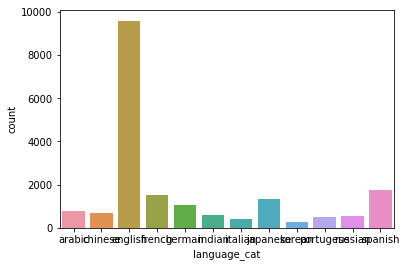

In [9]:
sns.countplot(x = 'language_cat', data =users)

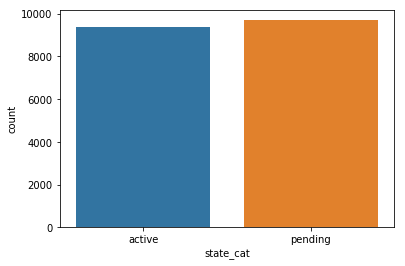

In [10]:
sns.countplot(x = 'state_cat', data =users)

### Create a data frame of weekly active users using pandas time series

below is the activated users over the lifetime of the dataset not the engaged users

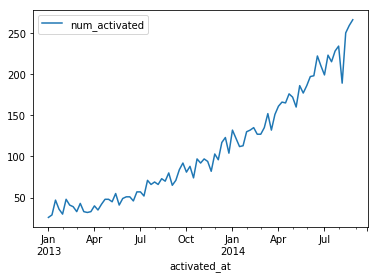

In [11]:
index = pd.DatetimeIndex(users['activated_at'])
w_act = pd.DataFrame(index = index)
w_act['num_activated'] = 1
w_act = w_act.resample('W').sum()
w_act.plot()

In [12]:
## get egaged userids who 2 weeks prior to Aug1 and 2 weeks after Aug 1 

engaged = events[events['event_type'] == 'engagement']
engaged['occurred_at'] = pd.to_datetime(engaged['occurred_at'])
engaged['event_name'] = engaged['event_name'].astype('category')
engaged['location'] = engaged['location'].astype('category')
engaged['device'] = engaged['device'].astype('category')

before_start = datetime.datetime(2014,7,21)
fail_time =  datetime.datetime(2014,8,1)
after_end =  datetime.datetime(2014,8,8)

before_cohort = engaged[(engaged['occurred_at'] > before_start)&(engaged['occurred_at'] < fail_time)]
after_cohort = engaged[(engaged['occurred_at'] >= fail_time)&(engaged['occurred_at'] < after_end)]


/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/nathaniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

### Now I've split the cohorts before and after the event I can segment the before and after events by device, location, and event_name

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

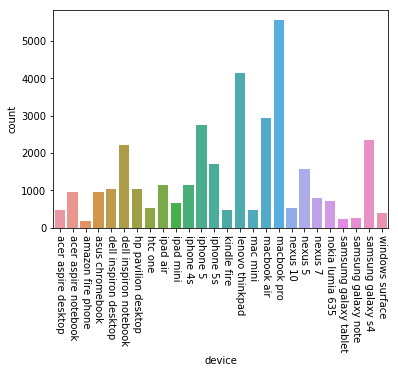

In [13]:
sns.countplot(x = 'device', data=before_cohort)
plt.xticks(rotation = -90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

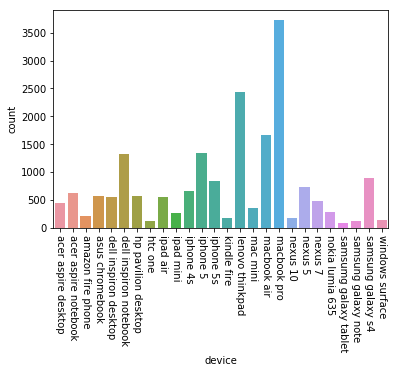

In [14]:
sns.countplot(x = 'device', data=after_cohort)
plt.xticks(rotation = -90)

### Now we want to see what types of emails these users saw before and after the event

In [15]:
# get emails before and after event
# get emails of engaged users from before jul 28 then segment their behaviour to see what happened to them after the 28 - this will require a join
# then segment behaviour again 

emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])
emails['action'] = emails['action'].astype('category')

emails_before = emails[(emails['occurred_at'] > before_start)&(emails['occurred_at'] < fail_time)]
emails_after = emails[(emails['occurred_at'] >= fail_time)&(emails['occurred_at'] < after_end)]
                       
                     

engaged_users_before = before_cohort['user_id'].unique()

e_filter = []

for i in range(len(emails_before)):
    if emails_before['user_id'].iloc[i] in engaged_users_before:
        e_filter += [True]
    else:
        e_filter += [False]
        
emails_before_engaged = emails_before[e_filter] 

e_filter = []

for i in range(len(emails_after)):
    if emails_after['user_id'].iloc[i] in engaged_users_before:
        e_filter += [True]
    else:
        e_filter += [False]
    
emails_after_engaged = emails_after[e_filter]
emails_after_unengaged = emails_after[np.logical_not(e_filter)]

emails_engaged = pd.concat([emails_before_engaged, emails_after_engaged], axis = 0)
emails_engaged['after'] = (emails['occurred_at'] >= fail_time) & (emails['occurred_at'] < after_end)
emails_engaged.head()
                                                               


,user_id,occurred_at,action,user_type,after
61,8.0,2014-07-22 09:30:00,sent_weekly_digest,3.0,False
62,8.0,2014-07-29 09:30:00,sent_weekly_digest,3.0,False
63,8.0,2014-07-29 09:30:27,email_open,3.0,False
64,8.0,2014-07-29 09:30:53,email_clickthrough,3.0,False
84,11.0,2014-07-22 09:30:00,sent_weekly_digest,1.0,False


### Plot the engaged usser segmentation before and after

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

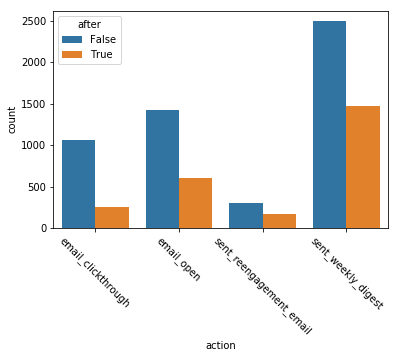

In [16]:
sns.countplot(x = 'action', data = emails_engaged, hue = 'after')
plt.xticks(rotation = -45)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

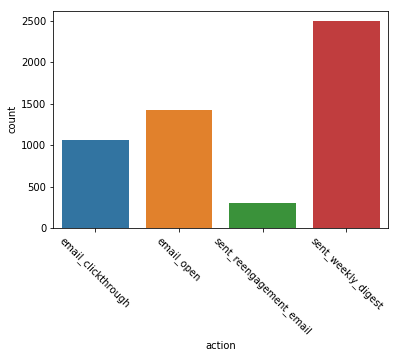

In [17]:
sns.countplot(x = 'action', data = emails_before_engaged)
plt.xticks(rotation = -45)


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

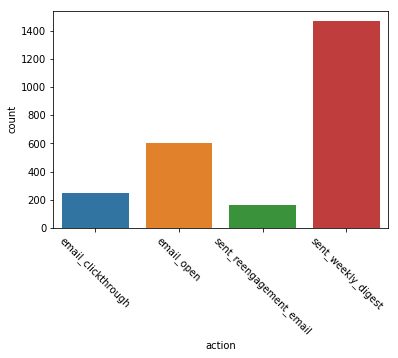

In [18]:
sns.countplot(x = 'action', data = emails_after_engaged)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

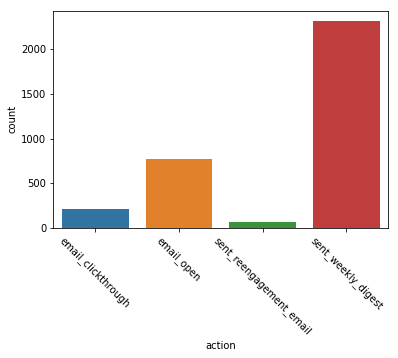

In [19]:
sns.countplot(x = 'action', data = emails_after_unengaged)
plt.xticks(rotation = -45)

## Modeling / Testing

we want to make sure that the equality of porportions is different betweeen before and after

In [20]:
from scipy.stats import chisquare
import numpy as np

obs = [emails_before_engaged['action'].value_counts()['email_clickthrough'], emails_before_engaged['action'].value_counts()['sent_weekly_digest']]
exp = [emails_after_engaged['action'].value_counts()['email_clickthrough'], emails_after_engaged['action'].value_counts()['sent_weekly_digest']]
obs1 = [emails_after_unengaged['action'].value_counts()['email_clickthrough'], emails_after_unengaged['action'].value_counts()['sent_weekly_digest']]
obs = obs + exp 

marginals = [5639,1900,3912,7651]
total = sum(marginals)

print(obs)


[1067, 2496, 248, 1469]


## Solution

### possible problems to explore
Fallout ( a new feature was added and others were upset they didn't see it )

A bad feature was added ( people didn't like it and left )

An email marketing failed ( people didn't like the email and left )

Server Crashed

### Evaluation of analysis
So far we've identified that the majority of the users speak english, there is a 50/50 split on active vs pending

the engaged cohort looks very similar before and after, they have the same locations, and similar event_names, and even similar device distributions

there appears to be a big loss all around ( by about a factor of 2 )

It appears that while the number of weekly digets sent were similar in number ( 2496 before , 1648 after), the clickthrough rate dramatically decreased ( 1067 before, 197 after ), that is the porportion of clickthrough / digest sent = (0.42 before vs 0.11 after) for users who were engaged before jul 28

this analysis is incomplete as i need to also consider the users who were engaged before, weren't engaged after, but still recieved the emails... ( there were 1000 users who were engaged before but left the following week, in order for there not to be a difference 800 would have had to clickthrough )


### Recommendations

Identify what happened to the weekly digest before and after this date to understand why the clickthrough rate dropped so dramatically  
